## Hypothesis

Today's close price is dependent on 



In [60]:
import yfinance as yf
from datetime import date
import pandas as pd
import numpy as np

ticker = 'SPY'
today = date.today()
start_date = "2020-01-01"
df = yf.download(ticker, start=start_date, end=today)
df.columns = df.columns.get_level_values(0)  # Flatten MultiIndex columns
df = df.reset_index()
lookback = 21

df['returns'] = df['Close'].pct_change()

# Rolling statistics with min_periods set
df['historical_volatility'] = df['returns'].rolling(window=lookback, min_periods=lookback).std()
df['adv'] = df['Volume'].rolling(window=lookback, min_periods=lookback).mean()

# Avoid division by zero in vol/adv
df['vol/adv'] = df['Volume'] / df['adv'].replace(0, np.nan)
df['vol/adv'] = df['vol/adv'].replace([np.inf, -np.inf], np.nan).fillna(0)

# True Range components
tr_components = pd.DataFrame({
    'h_l': df['High'] - df['Low'],
    'h_pc': (df['High'] - df['Close'].shift()).abs(),
    'l_pc': (df['Low'] - df['Close'].shift()).abs()
})
df['tr'] = tr_components.max(axis=1)

df['atr'] = df['tr'].rolling(window=lookback, min_periods=lookback).mean()

# Close z-score
rolling_mean = df['Close'].rolling(window=lookback, min_periods=lookback).mean()
rolling_std = df['Close'].rolling(window=lookback, min_periods=lookback).std().replace(0, np.nan)
df['close_zscore'] = (df['Close'] - rolling_mean) / rolling_std
df['close_zscore'] = df['close_zscore'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Shift returns to align with next day
df['returns'] = df['returns'].shift(-1)

# Fill remaining NaNs with zeros or drop if preferred
df.fillna(0, inplace=True)


C:\Users\nickt\AppData\Local\Temp\ipykernel_14076\1014157103.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=today)
[*********************100%***********************]  1 of 1 completed


In [64]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler

# Preparing data for PCA
features = ['vol/adv','historical_volatility','atr','close_zscore']
x = df[features].values
y = df['returns'].values

# Standardize features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Apply PCA
pca = PCA()
x_pca = pca.fit_transform(x_scaled)

# Check explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio per PC:", explained_variance)



Explained variance ratio per PC: [0.48659616 0.34172932 0.12758572 0.0440888 ]


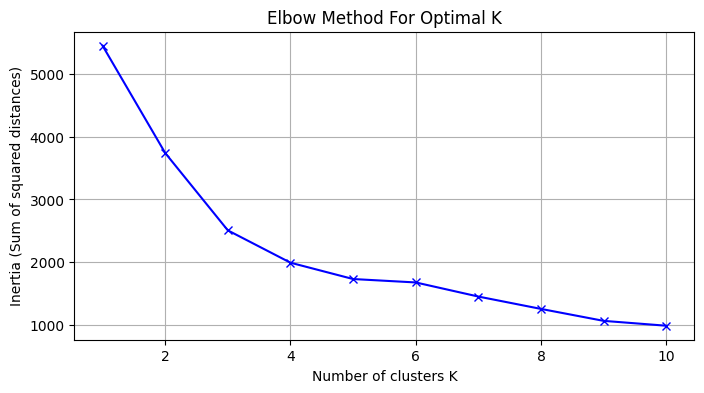

In [65]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

x_pca_reduced = x_pca[:, :3]  # Taking first 3 principal components
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_pca_reduced)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('Elbow Method For Optimal K')
plt.grid(True)
plt.show()

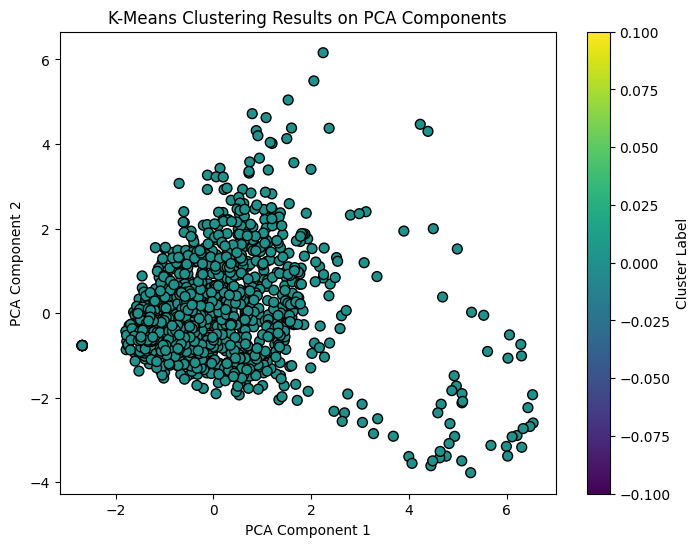

RMSE on test set: 0.015304


In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Choose k, for example, from plot elbow point
k_optimal = 1
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(x_pca_reduced)

# Example: x_pca_reduced is PCA transformed data (2D for plotting)
# and cluster_labels are the output labels from KMeans

# Plotting clusters
plt.figure(figsize=(8, 6))
plt.scatter(x_pca_reduced[:, 0], x_pca_reduced[:, 1], c=cluster_labels, cmap='viridis', 
            marker='o', edgecolor='k', s=50)
plt.title('K-Means Clustering Results on PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


# Step 7: Add cluster labels to PCA data as feature
X_final = np.hstack((x_pca_reduced, cluster_labels.reshape(-1, 1)))

# Step 8: Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.20, random_state=42, shuffle=True)

# Step 9: Train regression model to predict today's return
model = LinearRegression()
model.fit(X_train, y_train)

# Step 10: Predict and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE on test set: {rmse:.6f}")